Adrià Melús - 1527144

# Pràctica 3 d'Aprenentatge Computacional

## 1.Introducció

Elon Musk és considerada la persona amb més diners del planeta actualment; és el director executiu de la empresa aerospacial SpaceX i de la d'automòvils elèctrics Tesla, i fa poc va rebre el títol de la persona del any per part de la revista Time. 

Elon Musk també és algú que destaca per la seva activitat a Twitter, on publica memes o frases que deixen a tot el món pensant si realment les diu en serio. Mai està massa ocupat per comentar alguna broma o un pensament espontani. Tot i això, els seus intents per semblar graciós, per lo general acaben mostrant la seva irresponsabilitat al publicar tantes afirmacions confuses, insensibles o incorrectes.

Aquest és l'informe de  l'anàlisi de resultats en aprenentatge computacional d'una base de dades de kaggle que conté més de 25.000 tweets sobre Elon Musk: https://www.kaggle.com/taruntiwarihp/elon-musk-tweets. En honor al seu nou títol, que segons la publicació és otorgat a "la persona o persones que més han afectat les notícies i les nostres vides, cap a bé o cap a malament", 

<img src="../figures/elon1.jpg">

El propòsit principal d'aquest anàlisi és el de predir el sentiment d'un tweet segons sigui positiu o negatiu:

<img src="../figures/positive-negative.jpg">

### LLibreries

Per aquest projecte haurem de instalar les seguents llibreries:

Matplotlib, seaborn i wordcloud per la visualització gràfica de dades.

Pandas i numpy pel tractament d'informació.

SkLearn per l'entrenament dels nostres models.

NLTK pel processament de text.

imblearn pel "resampling" de la informació.

In [130]:
# Import 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import scikitplot as skplt
import plotly.graph_objs as go
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
from prettytable import PrettyTable
from plotly.offline import iplot

from imblearn.combine import SMOTETomek

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('stopwords', quiet=True);
nltk.download('vader_lexicon', quiet=True);

## 2. Informació de les dades

Primer de tot observarem detalladament les dades i les entendrem. A continuació, si és necessari, netejarem el dataset i el prepararem per analitzar-lo.

In [131]:
# Carregar el Dataset

dataset = "../dataset/Elon Musk.csv"
dades = pd.read_csv(dataset)

# Eliminem la primera columna perquè es tracta d'un index que no ens fa falta
dades.drop(dades.columns[0], inplace = True, axis = 1)
dades.head(1)


,tweets,sentiment
0,@elonmusk @realfuckingnews @business Ancient crypto? That's math... When I first learned what was a blockchain I wa… https://t.co/YepHdu4OEv,pos


In [132]:
# Quantes files i columnes hi ha al dataset? Cada fila representa un tweet
print("Hi ha {} columnes".format(dades.shape[1]), "i {} files.".format(dades.shape[0]))
print(dades.dtypes)

Hi ha 2 columnes i 25757 files.
tweets       object
sentiment    object
dtype: object


Com es pot observar, aquest dataset conté 25757 files i 2 columnes. Cada fila correspon a un tweet i inclou dues variables:

tweets: Variable de tipus object amb el contingut d'un tweet que esmenta @elonmusk.
sentiment: Variable de tipus object que indica el sentiment del tweet. L'atribut sentiment pot prendre dos valors: pos (positiu) o neg (negatiu)

Comprovem si hi ha cap valor nul:

In [133]:
null_counts = dades.isnull().sum()
null_counts[null_counts>0]

Series([], dtype: int64)

No s'ha trobat cap valor null o Nan, per tant no farà falta eliminar cap fila, de moment.

## 3. Anàlisi de la informació

In [134]:
dades.describe(exclude=[np.number]).drop("count")

,tweets,sentiment
unique,25418,2
top,@Twitter @elonmusk,pos
freq,67,22725


Hem vist que el dataset té tan sols dues variables rellevants on una és categòrica. Com es pot observar, hi ha 25.418 tweets únics i dos valors únics (pos i neg) de la variable sentiment.

Ara anem a visualitzar gràficament la distribució de la variable objectiu sentiment 

In [135]:
# Funció per la visualització en un gràfic de barres per la distribució de l'atribut x que es pasa com a paràmetre 
def plot_distributionCount(x, data):
    plt.subplots(figsize=(6, 4))
    sns.countplot(x=x, data=data, order=data[x].value_counts().index, palette='icefire_r')
    plt.xlabel('sentiment')
    plt.tight_layout()
    plt.show()

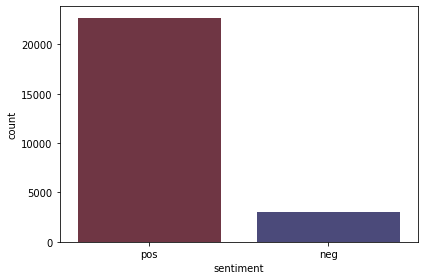

In [136]:
plot_distributionCount('sentiment',dades)

Com es pot observar, l'atribut sentiment prèn el valor positiu (88%) amb molta més freqüència que el negatiu (12%).

### 3.1. Anàlisi i neteja de tweets

Una vegada hem analitzat la informació i les variables de les que disposem, començarem a analitzar el text dels tweets. El tractament de tweets és important per tal de que posteriorment el text encaixi amb un model d'aprenentatge computacional  correctament.  

In [137]:
pd.set_option('max_colwidth', 700)
dades[['tweets', 'sentiment']].sample(5)

,tweets,sentiment
10257,How long do we think it'll be before @elonmusk claims that the Perseverance Rover landing was faked?\n\nOr he'd have… https://t.co/xgOUqBrHgY,pos
13832,@user66456888937 @exodus_io @elonmusk @CoinomiWallet @TrustWalletApp @ownrwallet Its all a bit new. Only bought my… https://t.co/JUNKOqN4GI,pos
932,@PutinRF_Eng2021 @JonesInfowars @mark_morphine @KamalaHarris @tomdelonge @BaggeDouche @KirkHammett @papahetfield81… https://t.co/04FIVnjAsX,pos
21822,@videomartian @elonmusk I agree but if it’s perceived as inevitable then there’s no reason not to pump your book. S… https://t.co/PY5TFm5FYB,neg
12146,💯❤️ https://t.co/y4IUCJyeIk,pos


Natural Language Toolkit (NLTK) és un conjunt de biblioteques i programes que ajuden al processament del llenguatge natural. Utilitzarem les eines que proporciona NLTK per "netejar" els tweets, és a dir, dividir-los en paraules i controlar la puntuació, els números, les @ o les paraules buides.

La següent funció converteix el tweet que es passa com a paràmetre en un text en minúscula, esborrra els numeros i puntuacions i separa el text en diferents paraules. L'idioma dels tweets és l'anglès, i un dels passos de la funció és eliminar les anomenades "stop words" d'aquest idioma. Les stop words son paraules freqüentment utilitzades (com preposicions) però que no aporten significat al tweet i per tant no són rellevants en aquest cas. També s'eliminen els símbols com l'@ i la paraula "elonmusk" que es troben a TOTS els tweets, per tant, no aporten iformació rellevant per cada tweet. 

In [138]:
# Converteix el tweet a un text net
def preProcessingTweet(tweet):
    text = tweet.lower()
    
    # treure puntuacio
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # treure números
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    #treure @
    text = [word for word in text if not any ("@" == c for c in word)]

    text = RegexpTokenizer(r'\w+').tokenize(str(text))
    
    # treure stop words
    text = [x for x in text if x not in stopwords.words('english')]

    #treure elonmusk
    text = [x for x in text if x != "elonmusk"]
    
    #treure enllaços https
    text = [x for x in text if x != "https"]
    
    # treure paraules buides
    text = [t for t in text if len(t) > 0]
    
    # unó de tot
    tweetNet = " ".join(text)
    return(tweetNet)

In [139]:
dades['tweetsNets'] = dades['tweets'].apply(lambda x: preProcessingTweet(x))

In [140]:
pd.set_option('max_colwidth', 1600)
dades.sample(8)

,tweets,sentiment,tweetsNets
24472,@AimanSa16701532 @elonmusk @business Dogecoin,pos,business dogecoin
25471,@elonmusk @business This is great to hear. People should be open to consider other opinions. Elon is not going ‘All… https://t.co/JMACl22F65,pos,business great hear people open consider opinions elon going
1245,After all this time? Always. \n\nA new start with futuristic man👑🤩\n@elonmusk \n#motivationalbook\n#ElonMusk\n#elonlife… https://t.co/It75CxQoqN,pos,time always n na new start futuristic n motivationalbook n n elonlife
7673,@elonmusk @NASA https://t.co/p7M9BvlrwK,pos,nasa
24013,"""If something is important enough, even if the odds are against you, you should still do it.""\n\n~@elonmusk",pos,something important enough even odds still
12074,Hey @elonmusk \n\nFew guys from @ioc_community are building a whole #universe #game within the #iOC blockchain. There… https://t.co/4dryh19es6,pos,hey n nfew guys ioc_community building whole universe game within ioc blockchain
3463,@elonmusk why not use ultracapacitor instead of heavy batteries? They are cheaper and more efficient\nOr at least mix of that,pos,use ultracapacitor instead heavy batteries cheaper efficient least mix
17943,@elonmusk @realfuckingnews @business somehow a yellow rock can be exchanged for real goods &amp; services\n\nsomehow a pl… https://t.co/6I0fcacoti,pos,realfuckingnews business somehow yellow rock exchanged real goods amp services n nsomehow pl


Hem afegit una nova columna amb els tweets nets, podem ara sí, observar el text per buscar dades rellevants sobre aquests,

### WordCloud per paraules positives i negatives

Una vegada hem netejat els tweets, podem donar una ullada a les dades de nou per buscar dades rellevants, com les paraules que més es repeteixen i les possibles relacions amb el sentiment del tweet. 

In [141]:
stop_words = set(STOPWORDS)
stop_words.update([x.lower() for x in list(dades["tweetsNets"][dades["tweetsNets"].notnull()].unique())])

In [142]:
def wordCloud(data, background_color, title):
    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = background_color, max_words = 500, stopwords = stop_words, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(title)
    plt.axis('off')

Separem els tweets positius i negatius:

In [143]:
df = dades[['tweets','tweetsNets','sentiment']]

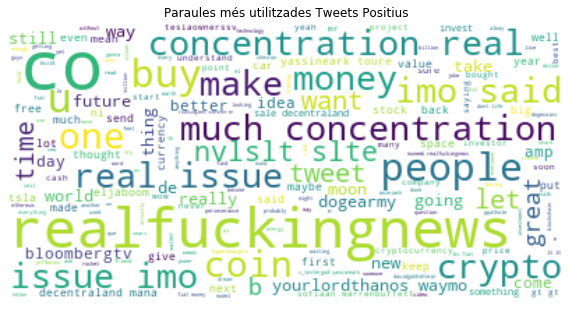

In [144]:
tweets_positius = df[df['sentiment'] == 'pos']
wordCloud(tweets_positius['tweetsNets'], 'white', "Paraules més utilitzades Tweets Positius")

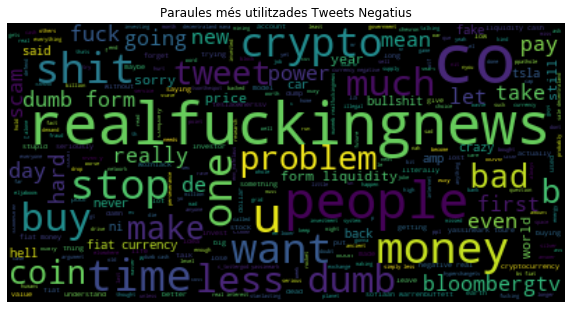

In [145]:
tweets_negatius = df[df['sentiment'] == 'neg']
wordCloud(tweets_negatius['tweetsNets'], 'black', "Paraules més utilitzades Tweets Negatius")

Després de fer les primeres proves amb WordCloud, es va millorar la funció prePreProcessingTweet per eliminar també la paraula "https", que fa referència a la gran quantitat d'enllaços que es troben freqüentment a tot tipus de tweets, ja siguin positius o negatius.

Una vegada realitzada aquesta millora, podem observar a les imatges que ha generat l'eina WordCloud els termes més repetits en els tweets positius i negatius.

## 4.Tractament de les dades

Abans de començar a crear el nostre model de predicció de sentiment, necessitem tractar les dades.

Primer de tot observem la distribució dels tweets respecte el seu sentiment:

Positius: 22725
Negatius: 3032


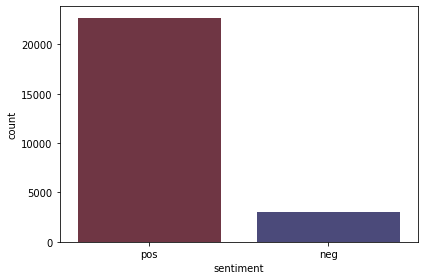

In [146]:
nTweets = df['sentiment'].value_counts()
print("Positius:",  nTweets[0])
print("Negatius:",  nTweets[1])

plot_distributionCount('sentiment',df)

La informació respecte els sentiments no està equilibrada. Això pot suposar un inconvenient alhora de la classificació ja que, per exemple, el model podria obtenir aprop d'un 85% només predint sempre positiu. Per tal de solucionar aquest desbalanç de dades, utilitzarem la llibreria imblearn.

La seguent classe SMOTETomek és una classe de la llibreria imblearn que combina tècniques de over-sampling i under-sampling:

In [147]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')

Separem les dades (tweets) en dos conjunts, l'utilitzat per entrenar el model (train set) i l'utilitzat per evaluar el model (test set):

In [148]:
vectorizer = CountVectorizer()

In [149]:
# La X serà el text dels tweets nets i la Y la variable sentiment.

X = vectorizer.fit_transform(df['tweetsNets'])
y = df['sentiment']

X_smt, y_smt = smt.fit_resample(X, y)

# Separem les dades en els conjunts de train i test:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size=0.3, random_state=100)

## 5. Creació del model

A continuació crearem varis models capaços de predir el sentiment d'un tweet sobre Elon Musk, amb l'objectiu de comparar-los entre ells per veure quin genera els millors resultats.

In [150]:
logisticRegression = LogisticRegression(solver='lbfgs', max_iter=400)
naiveBayes = MultinomialNB()
SVM = SVC()
randomForest = RandomForestClassifier(n_estimators=50)

models = [logisticRegression, naiveBayes, SVM, randomForest]

In [151]:
matriu_confusio = []
precisio = []
metriques = []

for model in models:
    model.fit(X_train, y_train)
    
    # Predicció 
    predictions = model.predict(X_test)
    
    # Guardem la precisió de la predicció que ha fet cada model
    prec = round(accuracy_score(y_test, predictions)*100)
    
    # Guardem la matriu de confusió de cada model
    model_cm = confusion_matrix(y_test.values, predictions)
    
    # Guardem el informe amb mètriques adicionals de la classificació de cada model
    informe = classification_report(y_test, predictions)
    
    matriu_confusio.append(model_cm)
    precisio.append(prec)
    metriques.append(informe)

In [152]:
precisio_models = PrettyTable()

precisio_models.add_column("Model", ['logisticRegression', 'Naive Bayes', 'SVM', 'randomForest'])
precisio_models.add_column("Precisió", precisio)
print(precisio_models)

+--------------------+----------+
|       Model        | Precisió |
+--------------------+----------+
| logisticRegression |   86.0   |
|    Naive Bayes     |   67.0   |
|        SVM         |   88.0   |
|    randomForest    |   83.0   |
+--------------------+----------+


No considerarem el model Naive Bayes a partir d'ara ja que ha obtingut una precisió molt inferior respecte els altres models

### 5.1. Matriu de confusió

Generem la matriu de confusió dels tres models:

In [153]:
def plot_confusionMatrix(matriu_confusio):
    plt.figure(figsize=(15,12))
    
    plt.subplot(2,2,1)
    plt.title("Logistic Regression - Matriu de confusió")
    sns.heatmap(matriu_confusio[0], annot = True, cmap="OrRd", fmt='.0f', cbar=False);
    
    plt.subplot(2,2,2)
    plt.title("SVM - Matriu de confusió")
    sns.heatmap(matriu_confusio[2], annot = True, cmap="OrRd", fmt='.0f',cbar=False);
    
    plt.subplot(2,2,3)
    plt.title("Random Forest - Matriu de confusió")
    sns.heatmap(matriu_confusio[3], annot = True, cmap="OrRd", fmt='.0f',cbar=False);
    
    plt.show()   

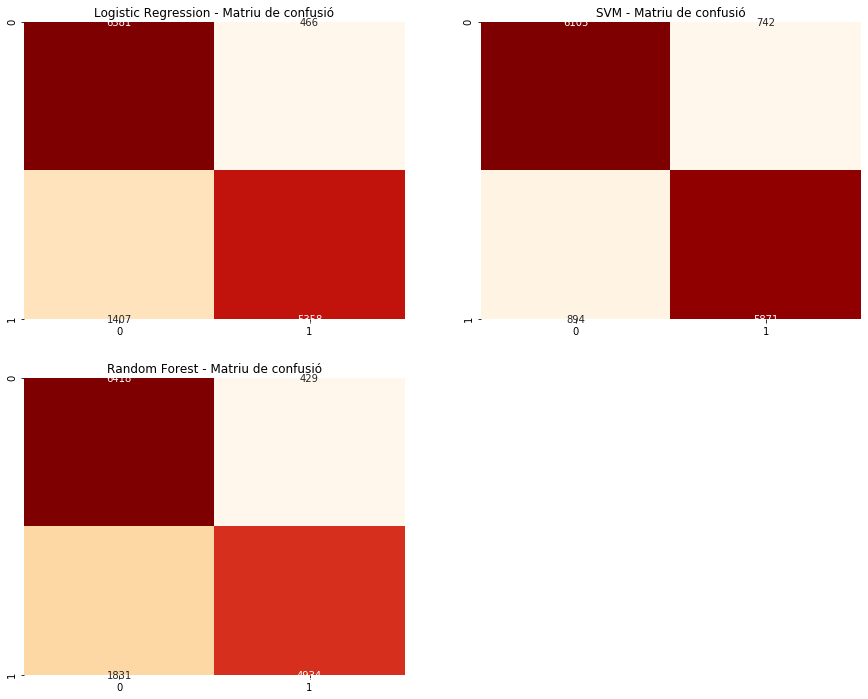

In [154]:
plot_confusionMatrix(matriu_confusio)

Les matrius de confusió anteriors ens permeten conéixer el nombre de verdaders positius i negatius i el de falsos positius i negatius de la seguent manera:

<img src="../figures/matriu-confusio.png">

### 5.2. Curves ROC

A més de fixar-nos en la precisió del model, podem ajudar-nos de la curve ROC per observar el rendiment del model. En altres paraules, indica la capacitat del model de distingir entre classes, en aquest cas, si el tweet denota un sentiment positiu o negatiu.

In [155]:
logisticRegression_prob = logisticRegression.predict_proba(X_test)

In [156]:
randomForest_prob = randomForest.predict_proba(X_test)

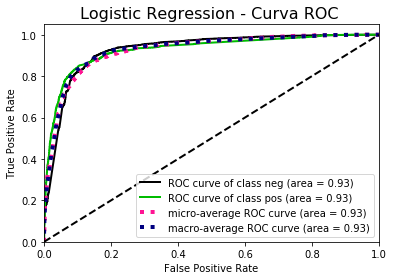

In [157]:
skplt.metrics.plot_roc(y_test, logisticRegression_prob) 
plt.title("Logistic Regression - Curva ROC ", fontsize=16)
plt.show()

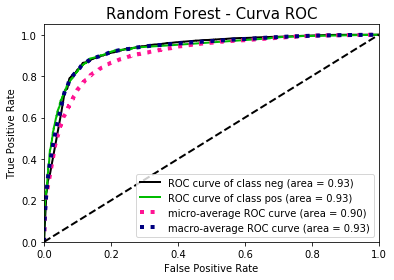

In [158]:
skplt.metrics.plot_roc(y_test, randomForest_prob) 
plt.title("Random Forest - Curva ROC", fontsize=15)
plt.show()

In [159]:
from sklearn.metrics import roc_auc_score
print("Puntuació AUC del model Logistic Regression: ", round((roc_auc_score(y_test, logisticRegression_prob[:,1], multi_class='ovr')),2))
print("Puntuació AUC del model Random Forest: ", round((roc_auc_score(y_test, randomForest_prob[:,1], multi_class='ovr')),2))

Puntuació AUC del model Logistic Regression:  0.93
Puntuació AUC del model Random Forest:  0.93


Com mostren les curves ROC, els models tenen aproximadament un 93% de probabilitats de distingir el sentiment positiu o negatiu correctament.

### 5.3. Més mètriques

Aquestes mètriques detallen les mètriques de classificació dels models que s'han seleccionat abans:

In [160]:
print("Logistic Regression Mètriques")
print(metriques[0])

Logistic Regression Mètriques
              precision    recall  f1-score   support

         neg       0.82      0.93      0.87      6847
         pos       0.92      0.79      0.85      6765

    accuracy                           0.86     13612
   macro avg       0.87      0.86      0.86     13612
weighted avg       0.87      0.86      0.86     13612



In [161]:
print("SVM Mètriques")
print(metriques[2])

SVM Mètriques
              precision    recall  f1-score   support

         neg       0.87      0.89      0.88      6847
         pos       0.89      0.87      0.88      6765

    accuracy                           0.88     13612
   macro avg       0.88      0.88      0.88     13612
weighted avg       0.88      0.88      0.88     13612



In [162]:
print("Random Forest Mètriques")
print(metriques[3])

Random Forest Mètriques
              precision    recall  f1-score   support

         neg       0.78      0.94      0.85      6847
         pos       0.92      0.73      0.81      6765

    accuracy                           0.83     13612
   macro avg       0.85      0.83      0.83     13612
weighted avg       0.85      0.83      0.83     13612



## 6. Resultats i conclusions


En aquesta pràctica hem vist com preprocessar el text segons la informació que ens interessa per solucionar un problema de classificació, en aquest cas, de un tweet sobre Elon Musk segons si el seu sentiment és positiu o negatiu.

El preprocessament de text ha permès "netejar" el tweet, eliminant simbols de @, enllaços i les conegudes com "stop words".Hem tractat les dades, agrupant-les segons el seu sentiment per analitzar i visualitzar les paraules més repetides per cada classe del atribut amb eines com WordCloud.

Hem vist com aplicar tècniques de resampling per dades no equitatives amb l'eina imblearn per, posteriorment poder entrenar els models amb els conjunts de test i entrenament i finalment hem vist com evaluar aquests models. Els tres models obtenen resultats molt similars com per elegir definitivament un. Probablement s'haurien d'entrenar els models i decantar-nos pel model que ofereixi més marge de millora.
 
